In [23]:
import matplotlib.pyplot as plt
import wradlib as wrl
import numpy as np

import matplotlib as mpl

In [58]:

angles = [0.5, 1.3, 2.4, 5.0, 7.0, 10.0, 15.0, 20.0] # Angle with surface

In [59]:
sitecoords = (64.026383, -22.635833, 47)
nrays = 420 # number of rays
nbins = 1000 # number of range bins
el = 0.5 # vertical antenna pointing angle (deg)
bw = 1.0 # half power beam width (deg)
range_res = 240. # range resolution (meters)

r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

In [60]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                      coord[..., 1],
                                      coord[..., 2], sitecoords)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

In [61]:
polcoords = coords[..., :2]
print("lon,lat,alt:", coords.shape)

lon,lat,alt: (420, 1000, 3)


In [62]:
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" %
      (lat.max(), lon.min(), lon.max(), lat.min()))

Radar bounding box:
	-20.47
61.69             66.36
	-24.80


In [63]:
# #rasterfile = wrl.util.get_wradlib_data_file('geo/bonn_gtopo.tif')
# # rasterfile = wrl.util.get_wradlib_data_file('geo/bonn_new.tif')

# ds = wrl.io.open_raster(rasterfile)
# rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=-32768.)

# # Clip the region inside our bounding box
# ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
# rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
# rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

# # Map rastervalues to polar grid points
# polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues,
#                                              polcoords, order=3,
#                                              prefilter=False)

In [64]:
def height_formatter(x, pos):
    x = (x - 6370000) / 1000
    fmt_str = '{:g}'.format(x)
    return fmt_str

def range_formatter(x, pos):
    x = x / 1000.
    fmt_str = '{:g}'.format(x)
    return fmt_str

C:\Users\sverrirhd\Anaconda3\envs\gis\lib\site-packages\wradlib\vis.py:953: MatplotlibDeprecationWarning: 
The ParasiteAxesAuxTransBase class was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ParasiteAxesBase instead.
  paax = ParasiteAxesAuxTrans(cgax, tr, "equal")


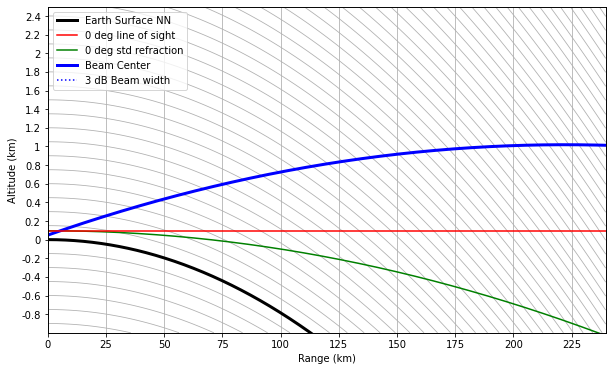

In [65]:
fig = plt.figure(figsize=(10, 6))

cgax, caax, paax = wrl.vis.create_cg(fig=fig, rot=0, scale=1)

# azimuth angle
angle = 0

# fix grid_helper
er = 6370000
gh = cgax.get_grid_helper()
gh.grid_finder.grid_locator2._nbins=80
gh.grid_finder.grid_locator2._steps=[1,2,4,5,10]

# calculate beam_height and arc_distance for ke=1
# means line of sight
bhe = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er, ke=1.)
ade = wrl.georef.bin_distance(r, 0, sitecoords[2], re=er, ke=1.)
nn0 = np.zeros_like(r)
# for nice plotting we assume earth_radius = 6370000 m
ecp = nn0 + er
# theta (arc_distance sector angle)
thetap = - np.degrees(ade/er) + 90.0

# zero degree elevation with standard refraction
bh0 = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er)

# plot (ecp is earth surface normal null)
bes, = paax.plot(thetap, ecp, '-k', linewidth=3, label='Earth Surface NN')
bc, = paax.plot(thetap, ecp + alt[angle, :], '-b', linewidth=3, label='Beam Center')
bc0r, = paax.plot(thetap, ecp + bh0 + alt[angle, 0] , '-g', label='0 deg Refraction')
bc0n, = paax.plot(thetap, ecp + bhe + alt[angle, 0], '-r', label='0 deg line of sight')
# b3db, = paax.plot(thetap, ecp + alt[angle, :]  + beamradius, ':b', label='+3 dB Beam width')
# paax.plot(thetap, ecp + alt[angle, :] - beamradius, ':b', label='-3 dB Beam width')

# orography
# paax.fill_between(thetap, ecp,
#                   ecp + polarvalues[angle, :],
#                   color='0.75')

# shape axes
cgax.set_xlim(0, np.max(ade))
cgax.set_ylim([ecp.min()-1000, ecp.max()+2500])
caax.grid(True, axis='x')
cgax.grid(True, axis='y')
cgax.axis['top'].toggle(all=False)
caax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(steps=[1,2,4,5,10], nbins=20, prune='both'))
caax.xaxis.set_major_locator(mpl.ticker.MaxNLocator())
caax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(height_formatter))
caax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(range_formatter))

caax.set_xlabel('Range (km)')
caax.set_ylabel('Altitude (km)')

legend = paax.legend((bes, bc0n, bc0r, bc, b3db),
                    ('Earth Surface NN', '0 deg line of sight', '0 deg std refraction', 'Beam Center', '3 dB Beam width'),
                    loc='upper left', fontsize=10)

plt.show()